# Nea. ancestry trajectories under different demographic models

This is a simple analysis of the effect of demography ($N_e$ in particular) after the out of Africa bottleneck on the efficacy of selection against weakly deleterious mutations introgressed from Neanderthals.

Neanderthal ancestry in the population is measured on 10,000 exonic sites and 40,000 non-exonic sites carrying fixed neutral Nea. markers. The positions of these sites were subsampled from the coordinates of sites from the archaic admixture array. Deleterious mutations are accumulating in exonic regions only.

I considered three demographic models (example in the plot bellow):

* classic Gravel et al. demographic model
* model of a constant $N_e = 10000$
* model of an initial linear growth until $N_e = 10000$ followed by a period exponential growth

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(lazyeval))
suppressPackageStartupMessages(library(reshape2))
library(stringr)

Conflicts with tidy packages ---------------------------------------------------


### Function definitions

In [3]:
##
## Create a data frame with Nea. trajectories from all replicates.
##
load_trajectories <- function(sim_dir, scenario, dominance, init_nea, sites_subset) {
    if (!sites_subset %in% c("exonic", "nonexonic"))
        stop("Illegal subset of sites specified (must be \"exonic\" or \"nonexonic\").")

    # compose the pattern describing all input tables
    pattern <- paste0(scenario,
                      "__h_", dominance,
                      "__init_nea_", init_nea,
                      "__rep_.*",
                      "__", sites_subset, "_sites.txt")

    # get paths of all input tables
    files <- list.files(sim_dir, pattern, full.names=TRUE)

    # load each table individually
    tables <- lapply(seq_along(files),
           function(i) {
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=i,
                              model=scenario,
                              sites=sites_subset,
                              h=dominance)
           })

    # merge all dataframes into one and return the result
    do.call(rbind, tables)
}


##
## Calculate and plot the trajectory of a given statistic of the Neanderthal
## ancestry in a population.
##
plot_statistic <- function(trajectories, statistic, log_scale=FALSE) {
    # calculate the mean of a given summary statistic over all replicates
    summarized <-
        group_by(trajectories, gen, sites, model, h) %>%
        summarize_(statistic=interp(~mean(var), var=as.name(statistic)))
    
    p <-
        ggplot(summarized, aes(gen, statistic)) +
            geom_line(aes(color=sites)) +
            facet_grid(h ~ model) + ylim(0, 0.125) +
            labs(title=paste("mean of the",
                             paste0(statistic, "s"),
                             "of Nea. ancestry change on the",
                             ifelse(log_scale, "log time scale", "normal time scale")),
                 y=statistic,
                 x="generations") +
            theme(legend.position="bottom")
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}


##
## Plot individual trajectories of a given statistic for each simulation
## replicate separately.
##
plot_replicates <- function(trajectories, statistic, dominance, log_scale=FALSE) {
    p <- 
        filter(trajectories, h == dominance) %>%
        melt(id=c("gen", "rep", "model", "sites"), measure=c(statistic)) %>%
        ggplot(aes(gen, value)) +
            geom_line(aes(color=factor(rep))) +
            facet_grid(model ~ sites) +
            ylim(0, 0.125) +
            labs(title=paste(statistic,
                             "Nea. ancestry change on the",
                             ifelse(log_scale, "log time scale", "normal time scale")),
                 y=statistic,
                 x="generations")
    
    if (log_scale) {
        p <- p + scale_x_log10()
    }
    
    p
}

### Load Nea. trajectories for all simulated models measured on the two types of Nea. neutral markers

The following measures of the Neanderthal ancestry in a population at a given time were recorded:

* mean
* median
* standard deviation
* min and max

In [4]:
sites <- c("exonic", "nonexonic")
models <- c("constant", "linear", "gravel")
dominance <- c("1.0", "0.9", "0.5", "0.1", "0.0")

In [5]:
traject_dir <- "../simulations/different_models"

In [6]:
trajectories <-
    expand.grid(dominance=dominance, model=models, site=sites) %>%
    apply(1, function(comb) {
        load_trajectories(traject_dir, comb["model"], comb["dominance"], init_nea="0.1", comb["site"])
    }) %>%
    bind_rows %>%
    as_tibble

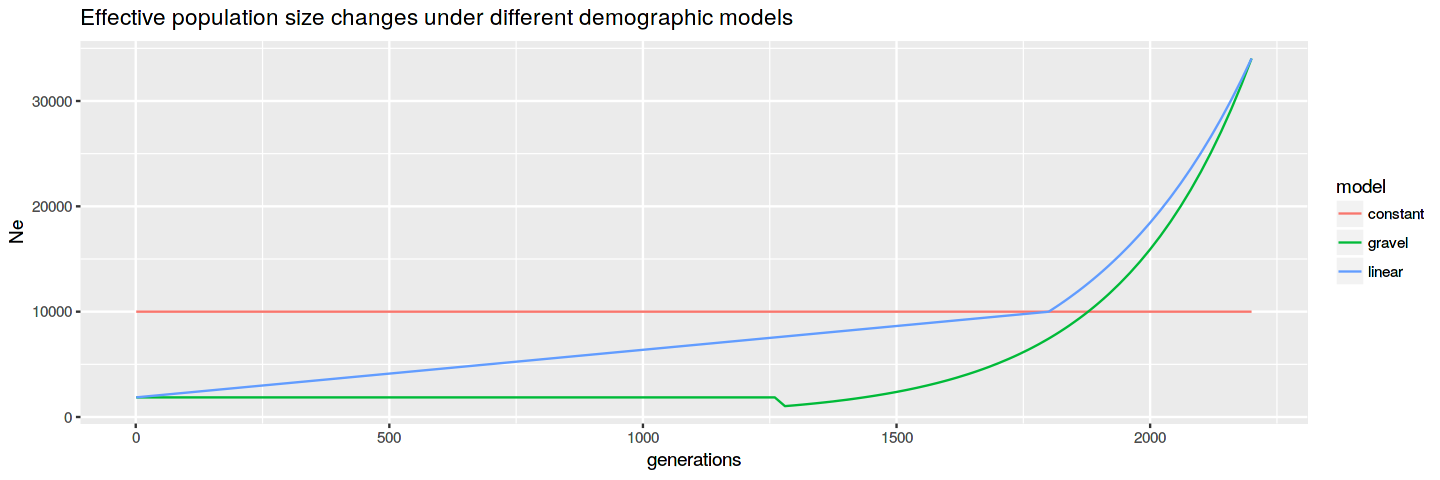

In [20]:
options(repr.plot.width=12, repr.plot.height=4)

# the custom SLiM output format includes a column with a Ne at each time-point
# this simply plots the values in this column for different simulation replicates
rbind(
    read.table(file.path(traject_dir, "constant__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE) %>% mutate(model="constant"),
    read.table(file.path(traject_dir, "gravel__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="gravel"),
    read.table(file.path(traject_dir, "linear__h_0.5__init_nea_0.1__rep_1__exonic_sites.txt"), header=TRUE)   %>% mutate(model="linear")
) %>%
ggplot(aes(gen, Ne, color=model)) +
    geom_line() +
    labs(title="Effective population size changes under different demographic models",
         x="generations")

# Plots of means of individual statistics (mean, median, sd...)

In [7]:
options(repr.plot.width=12, repr.plot.height=12)

## Mean Nea. ancestry over time

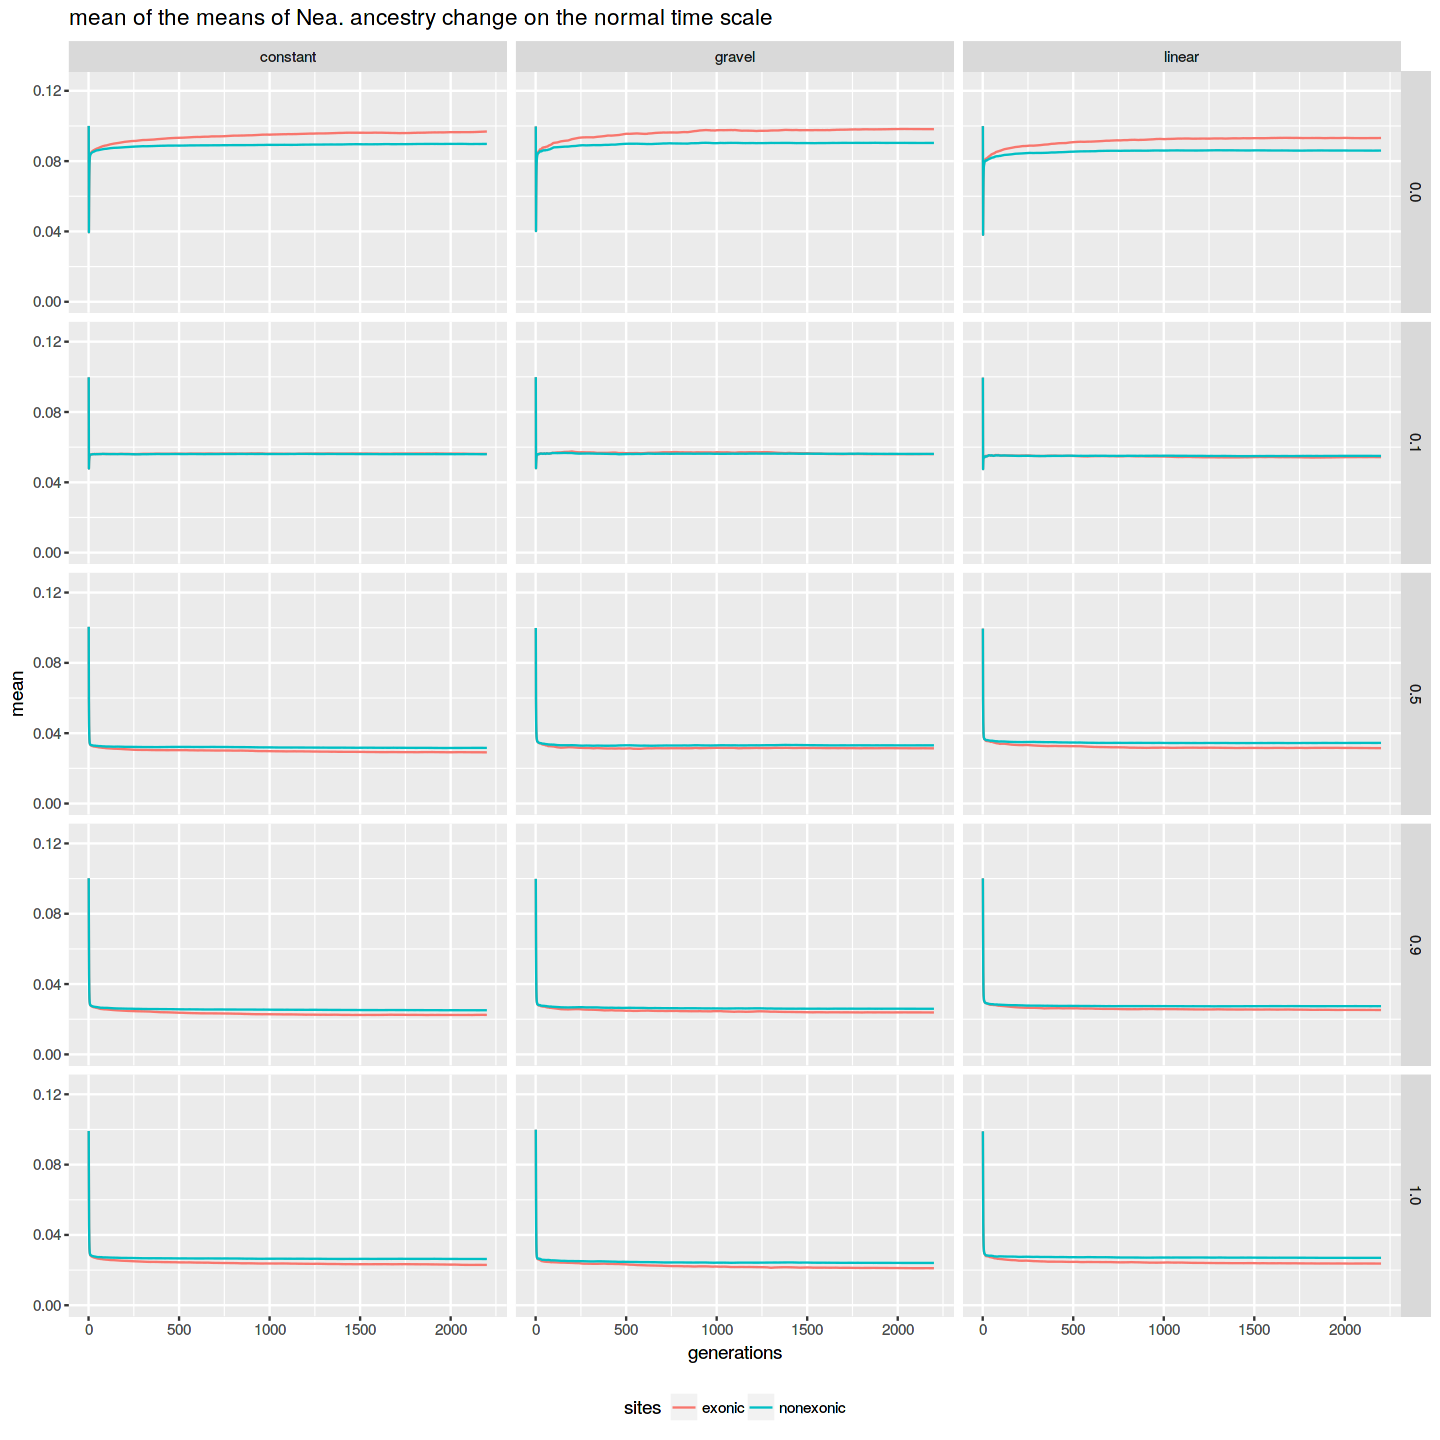

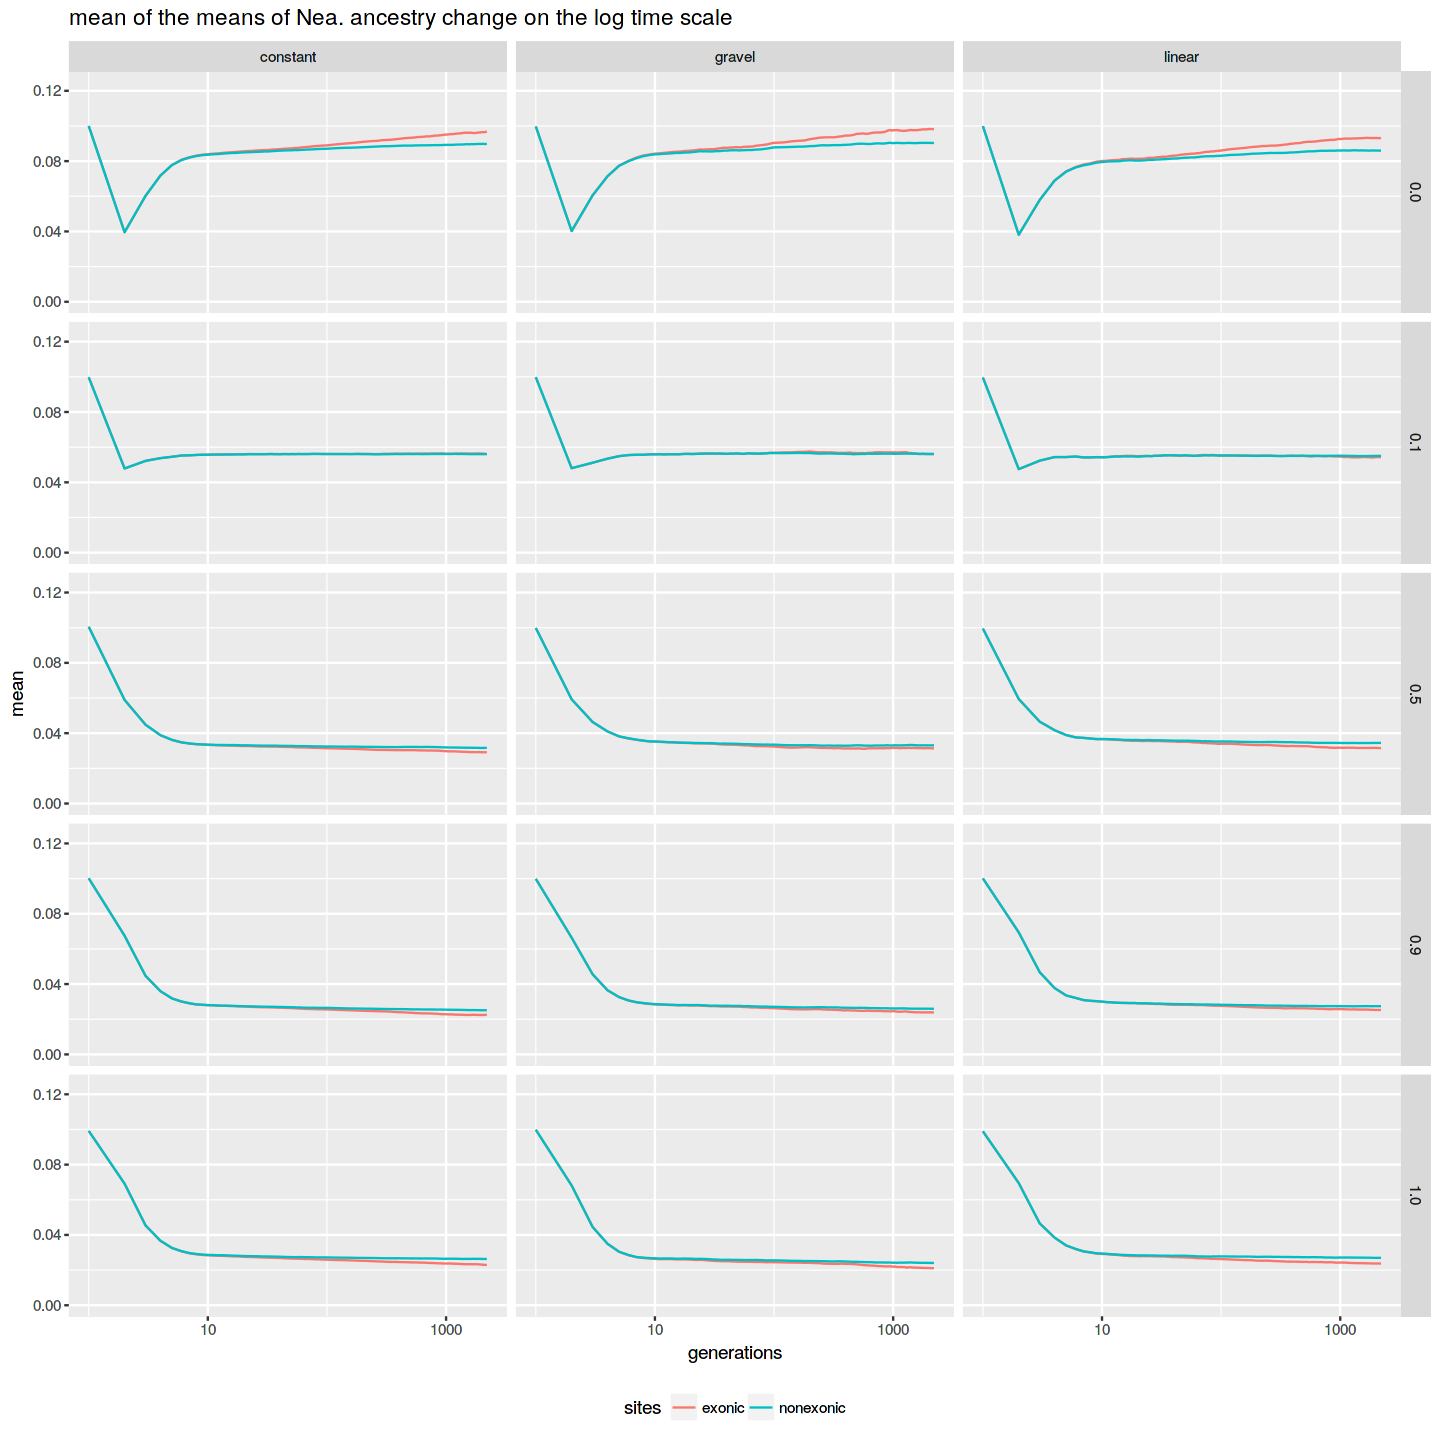

In [8]:
plot_statistic(trajectories, "mean")
plot_statistic(trajectories, "mean", log_scale=TRUE)

### Same as above, just zoomed in on to the 2%-4% section of the y-axis

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_path)."

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
"Removed 2 rows containing missing values (geom_path)."

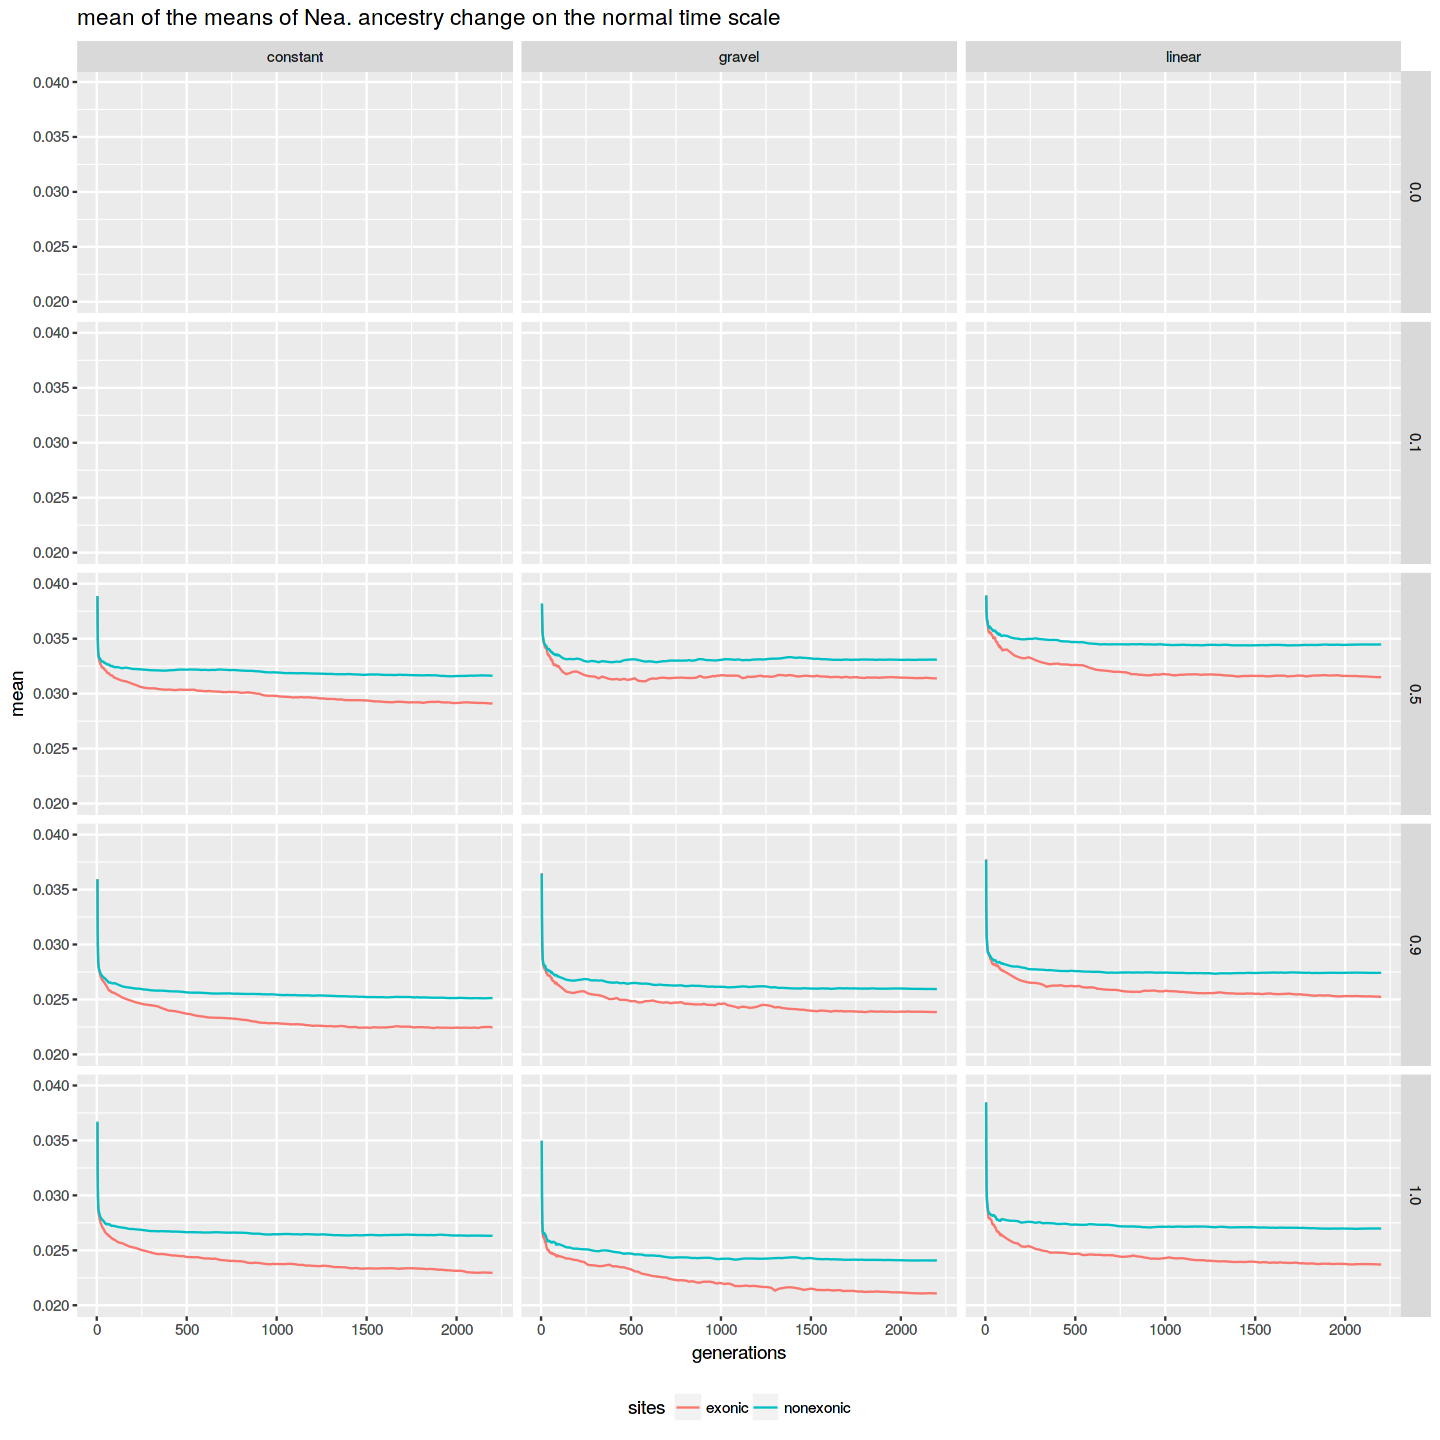

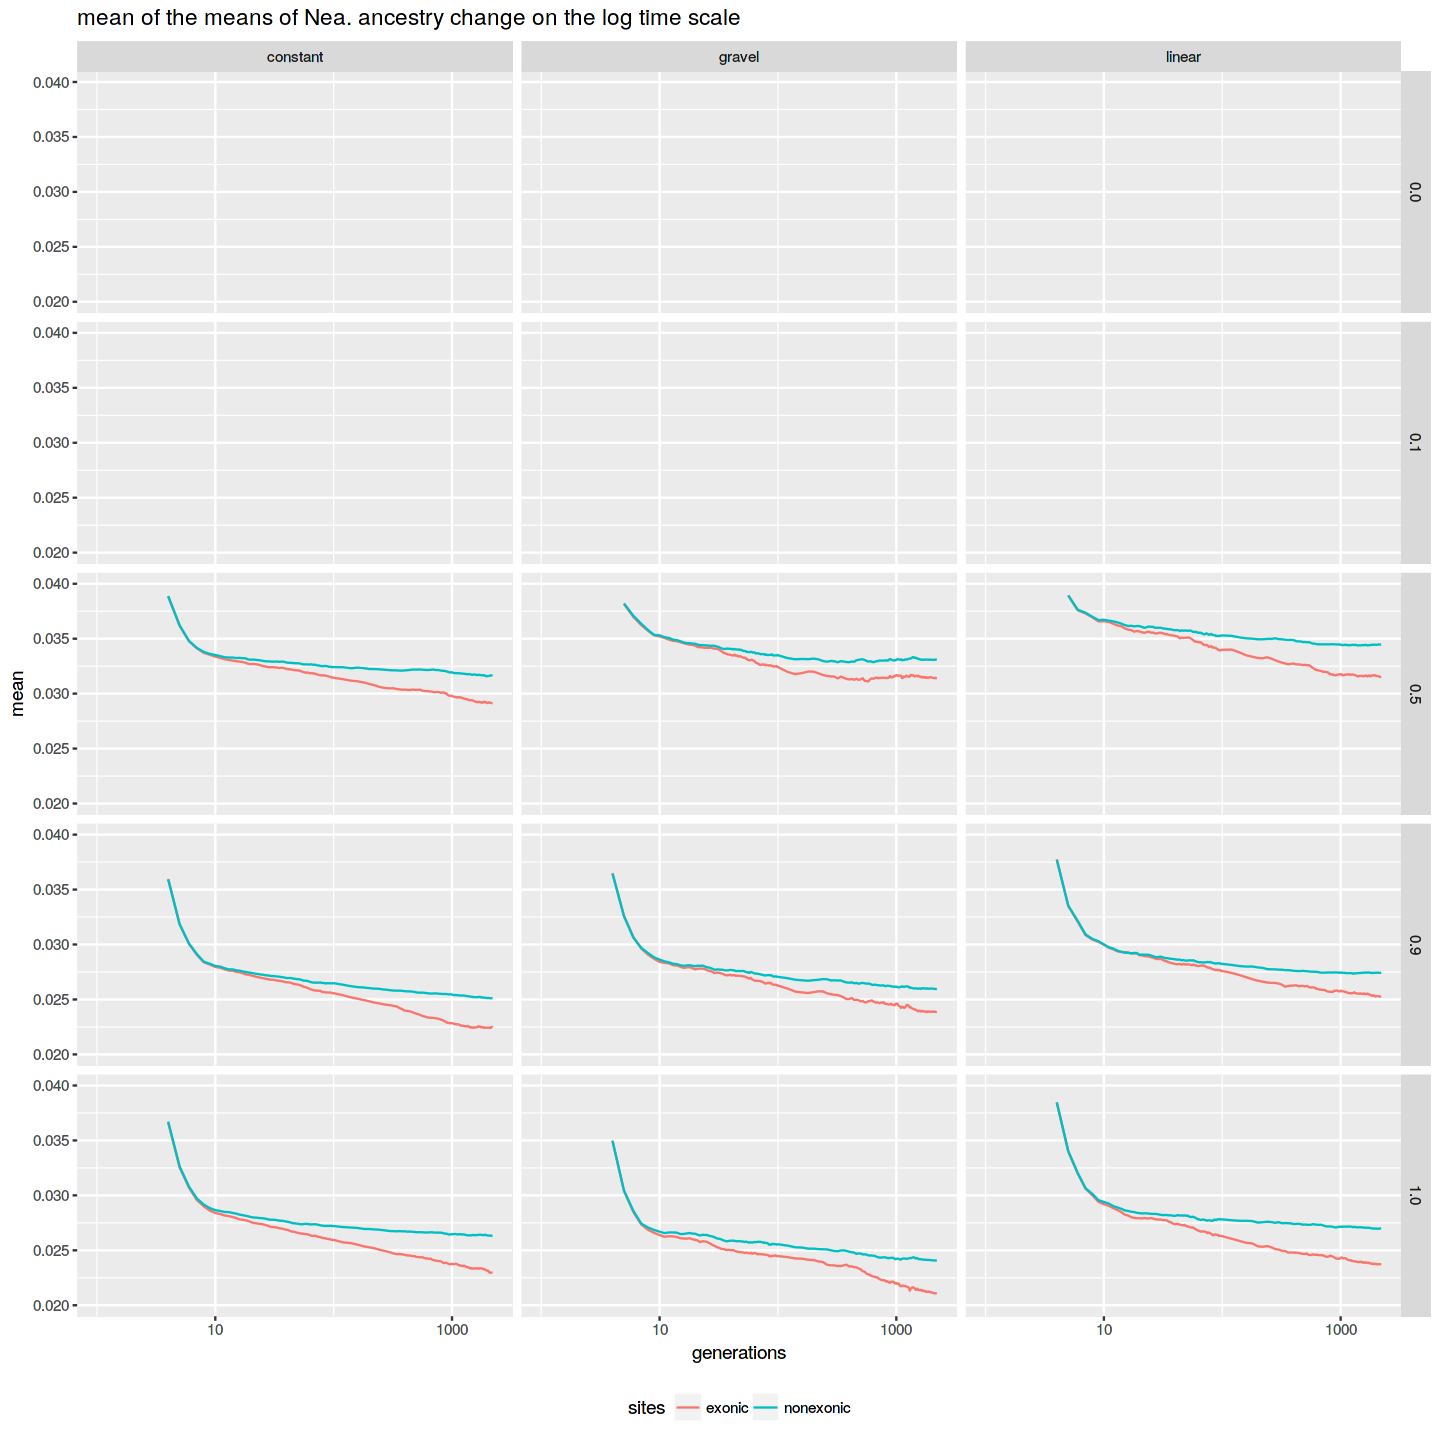

In [10]:
plot_statistic(trajectories, "mean") + ylim(0.02, 0.04)
plot_statistic(trajectories, "mean", log_scale=TRUE) + ylim(0.02, 0.04)

## Median of the Nea. ancestry over time

### Nea. trajectories on neutral exonic/non-exonic sites for each individual replicate

The slope doesn't seem to be different between different demographic models. Therefore, selection efficacy is not particularly different under different $N_e$ of the population that received gene flow from Neanderthals.

What changes is the variance in the final level of Nea. ancestry in the population. This is highest under the Gravel model, which is not surprising, because this model predicts a _very_ long period of a _very_ narrow bottleneck (i.e. high drift for > 20 thousand years).

The variance between different replicates is caused by drift very early after the admixture pulse (recombination early after admixture has a higher chance of removing larger blocks of Nea. ancestry).

<br><br><br><br><br>
# Mixture of dominances

## Simulating 10Mb region like a dummy

In [36]:
load_dominance_mix_trajectories <- function(sim_dir) {
    files <- list.files("../simulations/dominance_mix/", full.names=TRUE)
    tables <-
        lapply(seq_along(files),
               function(i) {
                   # extract parameters of a simulation from the simulation output filename
                   params <-
                       str_match(basename(files[i]), "^h_mix_(.*)_(.*)_(.*)__Ne_(.*)__r_(.*)__rep_(.*).txt") %>%
                       .[, 2 : ncol(.)] %>%
                       as.numeric
                   names(params) <- c("prop_add", "prop_partrec", "prop_rec", "Ne", "recomb_rate", "rep")
                   
                   # read the table with the simulation results and add parameters as additional columns
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=params["rep"],
                              prop_add=params["prop_add"],
                              prop_partrec=params["prop_partrec"],
                              prop_rec=params["prop_rec"],
                              recomb_rate=params["recomb_rate"])
               })
    bind_rows(tables) %>% as_tibble
}

In [37]:
trajectories <- load_dominance_mix_trajectories("../simulations/dominance_mix")

In [39]:
summarized_traj <-
    trajectories %>% group_by(gen, Ne, recomb_rate, prop_add, prop_partrec, prop_rec) %>% 
    summarize(stat=mean(mean)) %>% 
    mutate(props=paste(prop_add, prop_partrec, prop_rec))

In [38]:
options(repr.plot.width=12, repr.plot.height=5)

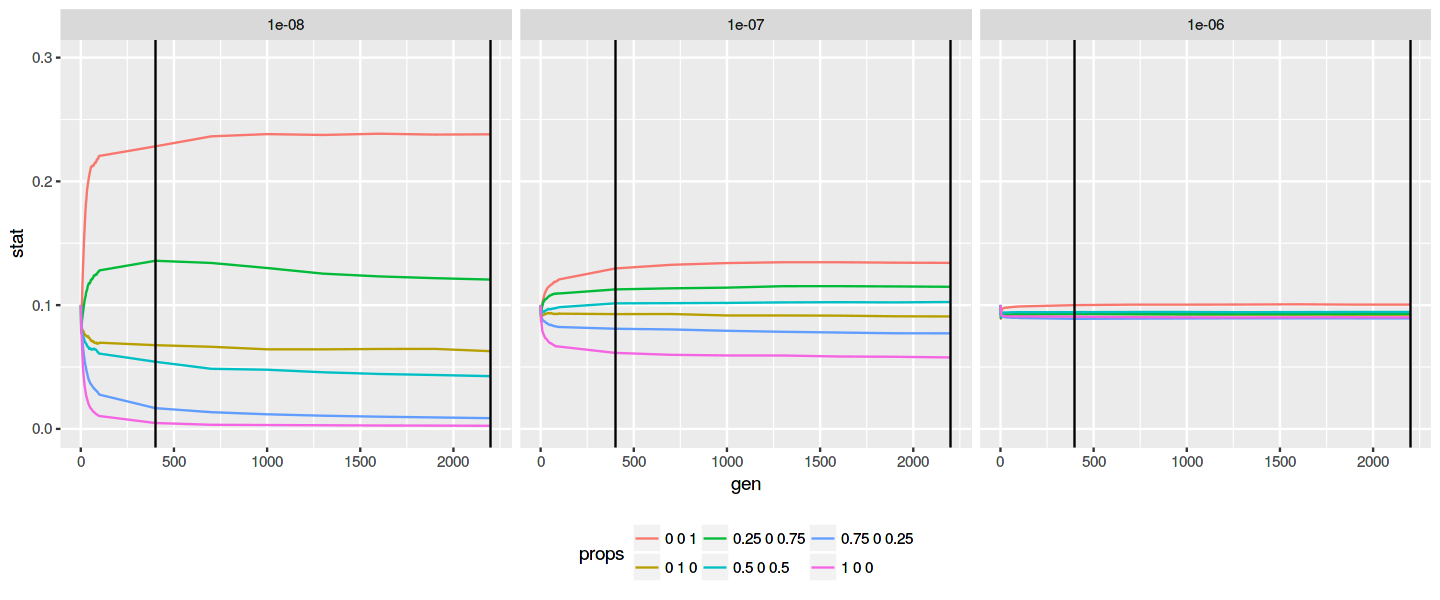

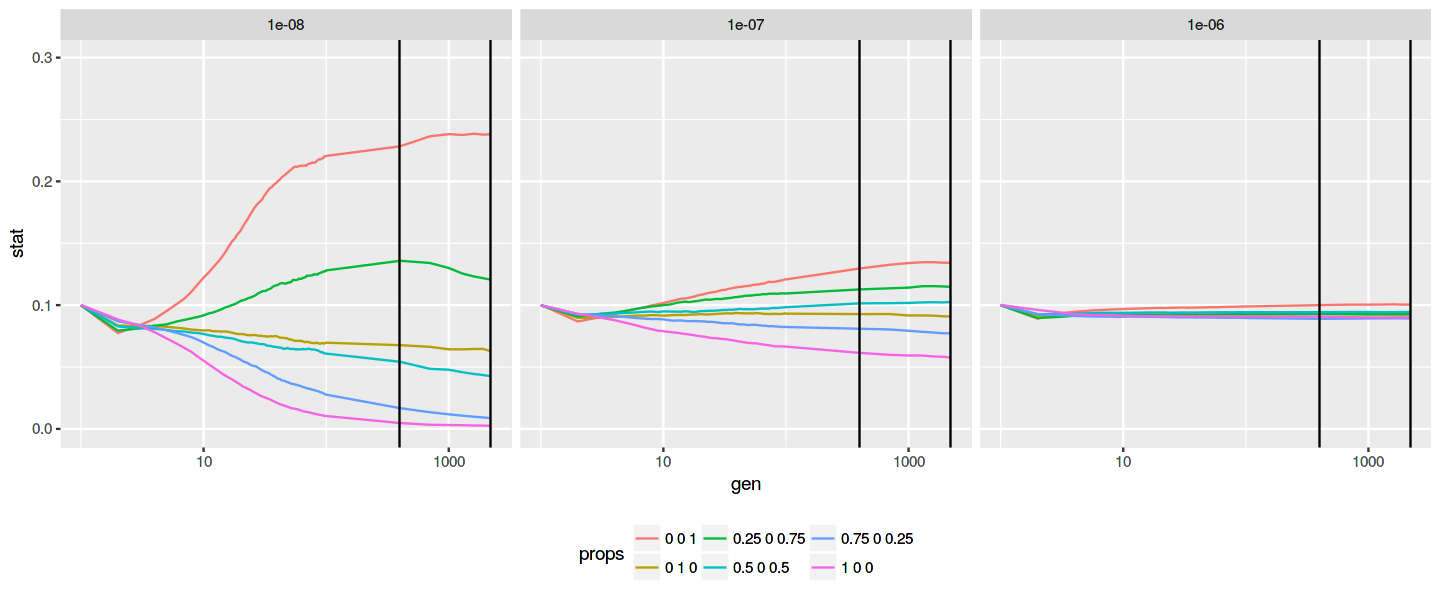

In [40]:
p <- ggplot(summarized_traj, aes(gen, stat, color=props)) +
    geom_line() +
    geom_vline(xintercept=c(400, 2200)) +
    facet_grid(. ~ recomb_rate) +
    coord_cartesian(ylim=c(0, 0.3)) +
    theme(legend.position="bottom")

p
p + scale_x_log10()

## Simulating whole exome + intergenic sites

In [35]:
load_dominance_mix_trajectories <- function(sim_dir) {
    files <- list.files("../simulations/dominance_mix/", pattern="exons_and_sites__.*__exonic_sites.txt", full.names=TRUE)
    tables <-
        lapply(seq_along(files),
               function(i) {
                   # extract parameters of a simulation from the simulation output filename
                   params <-
                       str_match(basename(files[i]), "^exons_and_sites__(.*)_(.*)__rep_(.*)__.*.txt") %>%
                       .[, 2 : ncol(.)] %>%
                       as.numeric
                   names(params) <- c("prop_add", "prop_rec", "rep")
                   
                   # read the table with the simulation results and add parameters as additional columns
                   read.table(files[i], header=TRUE) %>%
                       mutate(rep=params["rep"],
                              prop_add=params["prop_add"],
                              prop_rec=params["prop_rec"])
               })
    bind_rows(tables) %>% as_tibble
}

In [36]:
trajectories <- load_dominance_mix_trajectories("../simulations/dominance_mix")

In [37]:
summarized_traj <-
    trajectories %>% group_by(gen, prop_add, prop_rec) %>% 
    summarize(stat=mean(mean)) %>% 
    mutate(props=paste(prop_add, prop_rec))

In [38]:
options(repr.plot.width=9, repr.plot.height=4)

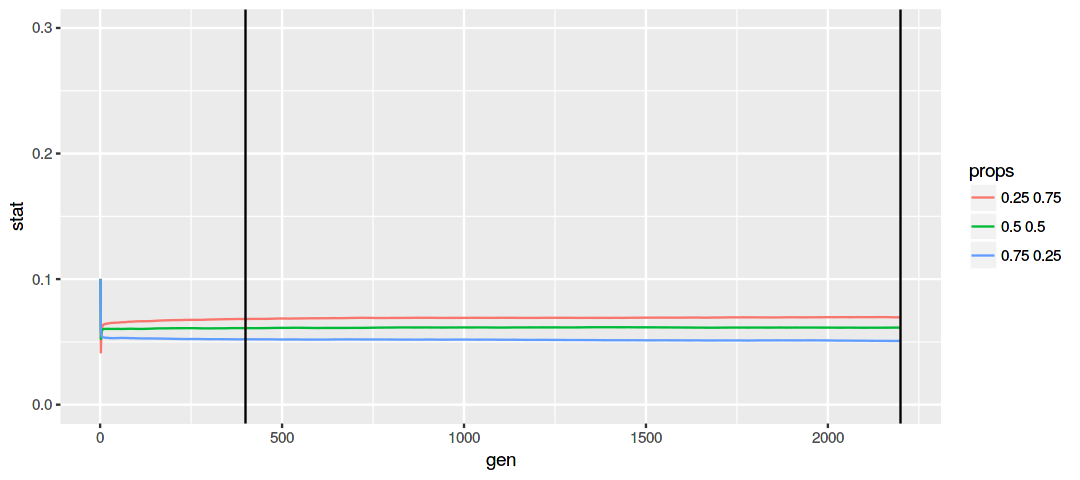

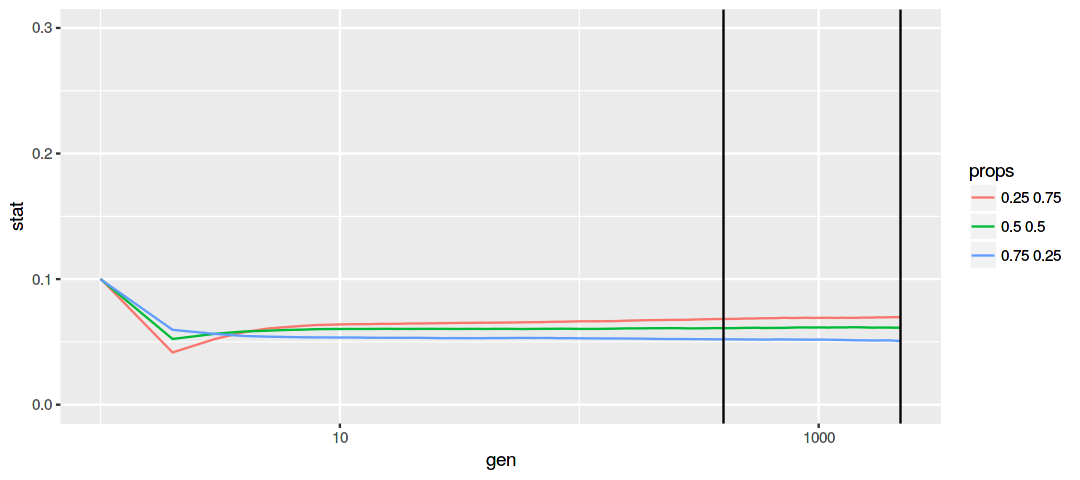

In [40]:
p <- ggplot(summarized_traj, aes(gen, stat, color=props)) +
    geom_line() +
    geom_vline(xintercept=c(400, 2200)) +
    coord_cartesian(ylim=c(0, 0.3))

p
p + scale_x_log10()

<br><br><br><br><br>
## A couple of dilution tests

In [7]:
options(repr.plot.width=12, repr.plot.height=5)

In [8]:
files <- list.files("../simulations/dilution/", "shortterm_dilution_.*__exonic.*", full.names = TRUE)
shortterm <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "short-term dilution", sites="exonic")
    }) %>% bind_rows()

files <- list.files("../simulations/dilution/", "longterm_dilution_.*__exonic.*", full.names = TRUE)
longterm <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "long-term dilution", sites="exonic")
    }) %>% bind_rows()

files <- list.files("../simulations/dilution/", "control.*__exonic.*", full.names = TRUE)
control <-    
    seq_along(files) %>% 
    lapply(function(i) {
        read.table(files[i], header = TRUE) %>%
        mutate(rep = i, model = "control", sites="exonic")
    }) %>% bind_rows()

In [9]:
do.call(rbind, list(shortterm, longterm, control)) -> x

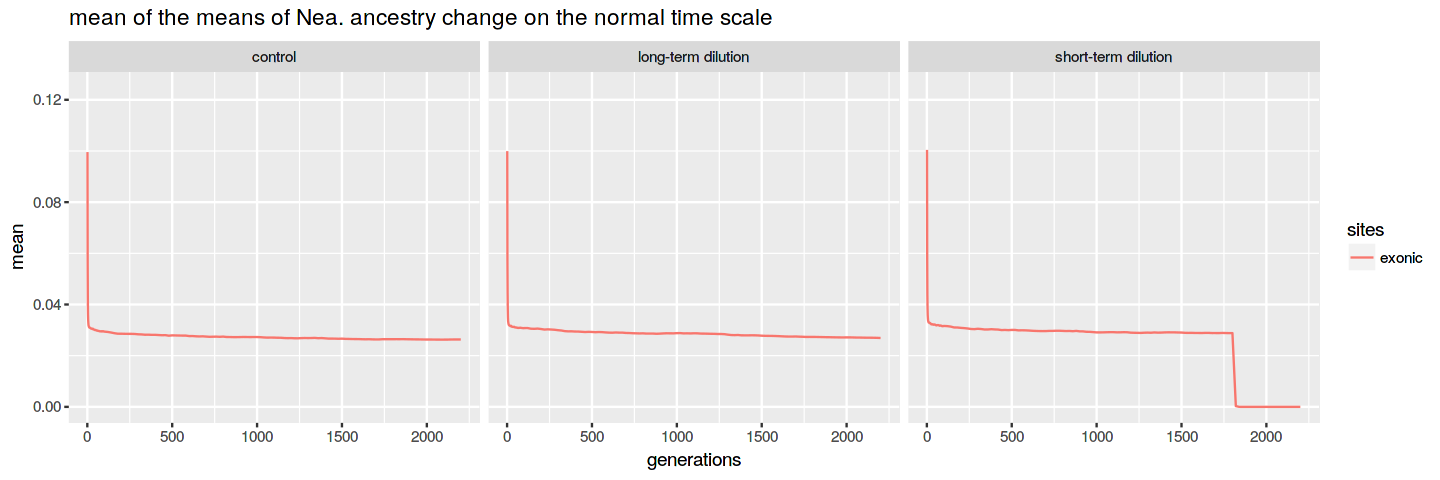

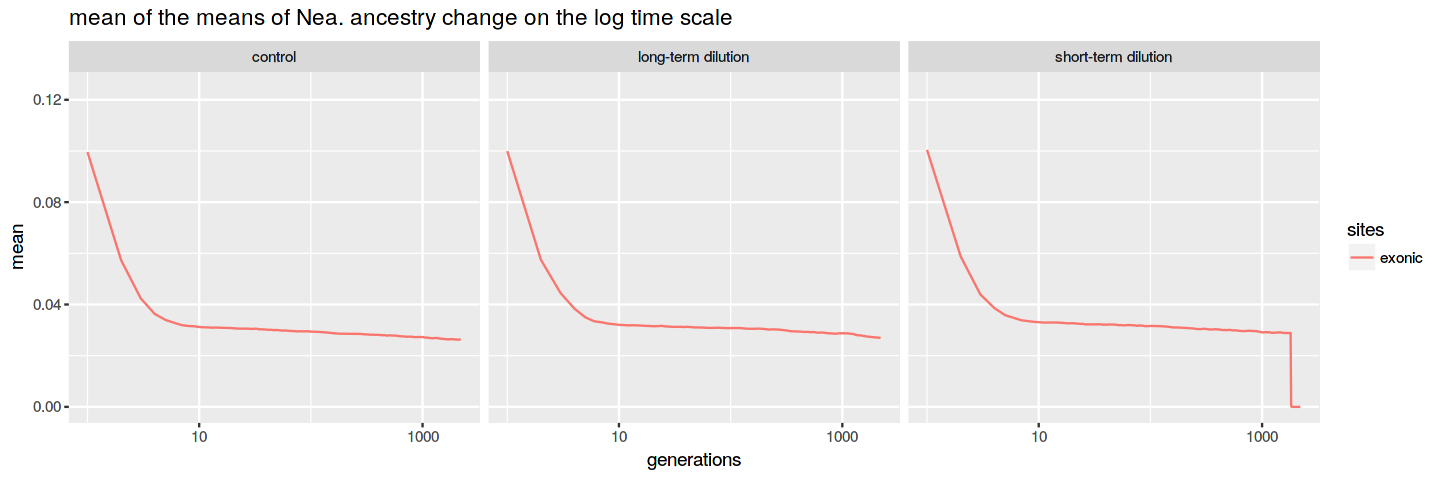

In [11]:
plot_statistic(x, "mean")
plot_statistic(x, "mean", log_scale=TRUE)